In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

In [2]:
import cartopy.crs as ccrs
import numpy as np

In [3]:
import tobac
import iris

In [4]:
print(tobac.__version__)

1.4.0


In [5]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

### Prepare precip dataset 

In [6]:
case1 = xr.open_dataset('../case1.nc')['tot_prec']
test1 = case1.to_iris()

In [7]:
test1 = case1.to_iris()
test1

Tot Prec (unknown),time,latitude,longitude
Shape,3,600,666
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x


In [8]:
time_coord = test1.coord("time")
dt = (  time_coord.units.num2date(time_coord.points[1]) - time_coord.units.num2date(time_coord.points[0])).seconds

In [9]:
dt

3600

In [10]:
# Grid spacing of the input data (in meter)
dxy = 4950 #(5km)

In [15]:
case2 = xr.open_dataset('../case2.nc')['tot_prec']
test2 = case2.to_iris()

In [16]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features={}
parameters_features['sigma_threshold']=1
parameters_features['threshold']=[1] #mm/h
parameters_features['n_min_threshold']=200 

## segmentation

In [17]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=1  # mm/h mixing ratio

In [18]:
paraplot={}
paraplot['cmap']=cm.BuPu;
paraplot['extend']='max';
paraplot['levels']=np.arange(0,10,1);

## Issue 1

In [19]:
print('starting feature detection with "weighted_diff" option')
Feat_wdiff = tobac.feature_detection_multithreshold(test1,dxy, position_threshold='weighted_diff',**parameters_features)
print('feature detection done')
print('starting feature detection with "weighted_abs" option')
Feat_wabs = tobac.feature_detection_multithreshold(test1,dxy, position_threshold='weighted_abs',**parameters_features)
print('feature detection done')
print('starting feature detection with "center" option')
Feat_center=tobac.feature_detection_multithreshold(test1,dxy, position_threshold='center',**parameters_features)
print('feature detection done')
print('starting feature detection with "extreme" option')
Feat_extreme=tobac.feature_detection_multithreshold(test1,dxy, position_threshold='extreme',**parameters_features)
print('feature detection done')

starting feature detection with "weighted_diff" option
feature detection done
starting feature detection with "weighted_abs" option
feature detection done
starting feature detection with "center" option
feature detection done
starting feature detection with "extreme" option
feature detection done


In [20]:
print('Starting segmentation ')
Mask1diff,FeatP1diff=tobac.segmentation_2D(Feat_wdiff,test1,dxy,**parameters_segmentation)
print('segmentation performed')

print('Starting segmentation ')
Mask1abs,FeatP1abs=tobac.segmentation_2D(Feat_wabs,test1,dxy,**parameters_segmentation)
print('segmentation performed')

print('Starting segmentation ')
Mask1center,FeatP1center=tobac.segmentation_2D(Feat_center,test1,dxy,**parameters_segmentation)
print('segmentation performed')

print('Starting segmentation ')
Mask1extreme,FeatP1extreme=tobac.segmentation_2D(Feat_extreme,test1,dxy,**parameters_segmentation)
print('segmentation performed')

Starting segmentation 
segmentation performed
Starting segmentation 
segmentation performed
Starting segmentation 
segmentation performed
Starting segmentation 
segmentation performed


In [21]:
print(len(FeatP1diff[FeatP1diff.ncells==0]), len(FeatP1abs[FeatP1abs.ncells==0]),
      len(FeatP1center[FeatP1center.ncells==0]),len(FeatP1extreme[FeatP1extreme.ncells==0]))

1 1 1 0


In [22]:
FeatP1diff.sort_values(by=['ncells'])[0:15]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells
1,1,17,288.477023,414.247467,215,1,2,2017-04-13 04:00:00,2017-04-13 04:00:00,-8.011034,-61.323864,0.0
2,2,6,281.184607,409.071490,219,1,3,2017-04-13 05:00:00,2017-04-13 05:00:00,-8.339193,-61.556783,148.0
3,2,36,394.507790,274.967544,215,1,4,2017-04-13 05:00:00,2017-04-13 05:00:00,-3.239649,-67.591461,148.0
0,0,54,404.286383,284.624262,280,1,1,2017-04-13 03:00:00,2017-04-13 03:00:00,-2.799613,-67.156908,236.0


In [23]:
tt = '2017-4-13T5:00';
for i in np.arange(3,5):
    print(xr.DataArray.from_iris(Mask1diff).sel(time=tt).where(xr.DataArray.from_iris(Mask1diff)==i).count().values)

144
148


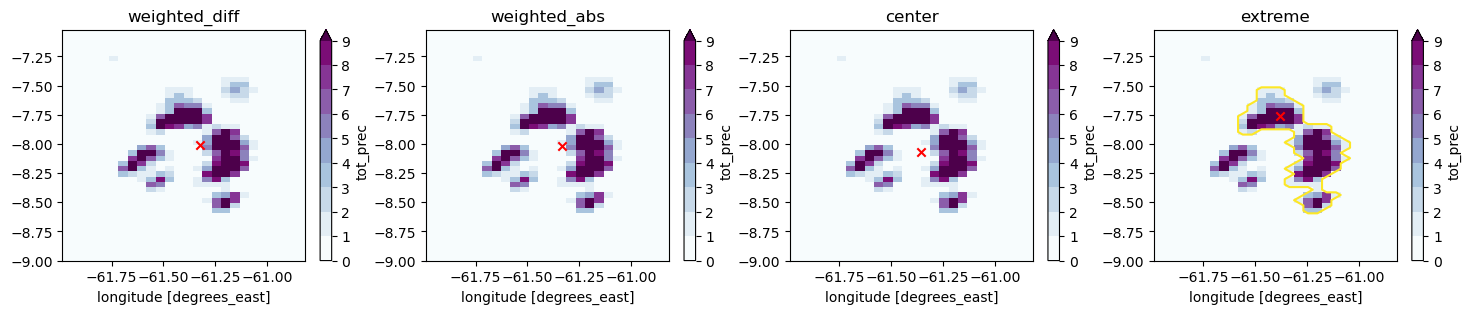

In [24]:
fig_map,ax=plt.subplots(1,4,figsize=(18,3)); xi = -62; xf = -60.8; yi = -9; yf = -7; tt = '2017-4-13T04:00';
labels=['weighted_diff', 'weighted_abs', 'center' , 'extreme' ]

for i in np.arange(4):
    xr.DataArray.from_iris(test1).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot(ax=ax[i],**paraplot)
    
ax[0].scatter(x=FeatP1diff[pd.to_datetime(FeatP1diff.timestr)==tt]['longitude'].values, 
            y=FeatP1diff[pd.to_datetime(FeatP1diff.timestr)==tt]['latitude'].values, color='r',marker='x', label="Detected Features"); 
xr.DataArray.from_iris(Mask1diff).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot.contour(ax=ax[0],levels=[1],color='orange');
ax[1].scatter(x=FeatP1abs[pd.to_datetime(FeatP1abs.timestr)==tt]['longitude'].values, 
            y=FeatP1abs[pd.to_datetime(FeatP1abs.timestr)==tt]['latitude'].values, color='r',marker='x', label="Detected Features"); 
xr.DataArray.from_iris(Mask1abs).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot.contour(ax=ax[1],levels=[1],color='orange');
ax[2].scatter(x=FeatP1center[pd.to_datetime(FeatP1center.timestr)==tt]['longitude'].values, 
            y=FeatP1center[pd.to_datetime(FeatP1center.timestr)==tt]['latitude'].values, color='r',marker='x', label="Detected Features"); 
xr.DataArray.from_iris(Mask1center).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot.contour(ax=ax[2],levels=[1],color='orange');
ax[3].scatter(x=FeatP1extreme[pd.to_datetime(FeatP1extreme.timestr)==tt]['longitude'].values, 
            y=FeatP1extreme[pd.to_datetime(FeatP1extreme.timestr)==tt]['latitude'].values, color='r',marker='x', label="Detected Features"); 
xr.DataArray.from_iris(Mask1extreme).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot.contour(ax=ax[3],levels=[1],color='orange');
for i in np.arange(4):
    ax[i].set_ylabel(''); ax[i].set_title(labels[i]);

## Issue 2 

In [25]:
print('starting feature detection with "weighted_diff" option')
Feat2_wdiff = tobac.feature_detection_multithreshold(test2,dxy, position_threshold='weighted_diff',**parameters_features)
print('feature detection done')
print('starting feature detection with "weighted_abs" option')
Feat2_wabs = tobac.feature_detection_multithreshold(test2,dxy, position_threshold='weighted_abs',**parameters_features)
print('feature detection done')
print('starting feature detection with "center" option')
Feat2_center=tobac.feature_detection_multithreshold(test2,dxy, position_threshold='center',**parameters_features)
print('feature detection done')
print('starting feature detection with "extreme" option')
Feat2_extreme=tobac.feature_detection_multithreshold(test2,dxy, position_threshold='extreme',**parameters_features)
print('feature detection done')

starting feature detection with "weighted_diff" option
feature detection done
starting feature detection with "weighted_abs" option
feature detection done
starting feature detection with "center" option
feature detection done
starting feature detection with "extreme" option
feature detection done


In [26]:
print('Starting segmentation ')
Mask2diff,FeatP2diff=tobac.segmentation_2D(Feat2_wdiff,test2,dxy,**parameters_segmentation)
print('segmentation performed')

print('Starting segmentation ')
Mask2abs,FeatP2abs=tobac.segmentation_2D(Feat2_wabs,test2,dxy,**parameters_segmentation)
print('segmentation performed')

print('Starting segmentation ')
Mask2center,FeatP2center=tobac.segmentation_2D(Feat2_center,test2,dxy,**parameters_segmentation)
print('segmentation performed')

print('Starting segmentation ')
Mask2extreme,FeatP2extreme=tobac.segmentation_2D(Feat2_extreme,test2,dxy,**parameters_segmentation)
print('segmentation performed')

Starting segmentation 
segmentation performed
Starting segmentation 
segmentation performed
Starting segmentation 
segmentation performed
Starting segmentation 
segmentation performed


In [27]:
print(len(FeatP2diff[FeatP2diff.ncells==0]), len(FeatP2abs[FeatP2abs.ncells==0]),
      len(FeatP2center[FeatP2center.ncells==0]),len(FeatP2extreme[FeatP2extreme.ncells==0]))
print(len(FeatP2diff[FeatP2diff.ncells>=200]), len(FeatP2abs[FeatP2abs.ncells>=200]),
      len(FeatP2center[FeatP2center.ncells>=200]),len(FeatP2extreme[FeatP2extreme.ncells>=200]))

0 0 0 0
26 44 0 13


In [28]:
FeatP2diff[FeatP2diff.ncells>=0].sort_values(by=['ncells'])[0:18]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells
28,1,246,233.502208,300.575264,266,1,29,2017-04-03 20:00:00,2017-04-03 20:00:00,-10.484901,-66.439113,21
26,1,69,149.545828,322.209144,236,1,27,2017-04-03 20:00:00,2017-04-03 20:00:00,-14.262938,-65.465589,21
30,1,267,251.352708,340.357857,642,1,31,2017-04-03 20:00:00,2017-04-03 20:00:00,-9.681628,-64.648896,21
31,1,291,259.527270,281.243524,274,1,32,2017-04-03 20:00:00,2017-04-03 20:00:00,-9.313773,-67.309041,21
32,1,298,259.653784,376.106273,313,1,33,2017-04-03 20:00:00,2017-04-03 20:00:00,-9.308080,-63.040218,21
33,1,310,272.332882,530.179472,589,1,34,2017-04-03 20:00:00,2017-04-03 20:00:00,-8.737520,-56.106924,21
34,1,356,292.727460,236.387927,416,1,35,2017-04-03 20:00:00,2017-04-03 20:00:00,-7.819764,-69.327543,21
35,1,361,305.552063,476.952894,558,1,36,2017-04-03 20:00:00,2017-04-03 20:00:00,-7.242657,-58.502120,21
36,1,413,335.951060,239.487649,204,1,37,2017-04-03 20:00:00,2017-04-03 20:00:00,-5.874702,-69.188056,21
37,1,425,336.774274,624.860775,214,1,38,2017-04-03 20:00:00,2017-04-03 20:00:00,-5.837658,-51.846265,21


In [29]:
FeatP2diff[(FeatP2diff.feature>27)&(FeatP2diff.feature<36)]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells
27,1,196,216.141320,266.053409,408,1,28,2017-04-03 20:00:00,2017-04-03 20:00:00,-11.266141,-67.992597,21
28,1,246,233.502208,300.575264,266,1,29,2017-04-03 20:00:00,2017-04-03 20:00:00,-10.484901,-66.439113,21
29,1,262,233.105370,350.782937,202,1,30,2017-04-03 20:00:00,2017-04-03 20:00:00,-10.502758,-64.179768,21
30,1,267,251.352708,340.357857,642,1,31,2017-04-03 20:00:00,2017-04-03 20:00:00,-9.681628,-64.648896,21
31,1,291,259.527270,281.243524,274,1,32,2017-04-03 20:00:00,2017-04-03 20:00:00,-9.313773,-67.309041,21
32,1,298,259.653784,376.106273,313,1,33,2017-04-03 20:00:00,2017-04-03 20:00:00,-9.308080,-63.040218,21
33,1,310,272.332882,530.179472,589,1,34,2017-04-03 20:00:00,2017-04-03 20:00:00,-8.737520,-56.106924,21
34,1,356,292.727460,236.387927,416,1,35,2017-04-03 20:00:00,2017-04-03 20:00:00,-7.819764,-69.327543,21


In [30]:
tt = '2017-4-3T20:00';
for i in np.arange(28,37): #according to numbers in features
    print(xr.DataArray.from_iris(Mask2diff).sel(time=tt).where(xr.DataArray.from_iris(Mask2diff)==i).count().values)

0
0
150
576
175
252
0
0
460


In [31]:
sizes_wdiff = tobac.analysis.calculate_area(Feat2_wdiff,Mask2diff,method_area='latlon')

In [32]:
sizes_wdiff[pd.to_datetime(sizes_wdiff.timestr)==tt].area/1e6

26     1212.485123
27             NaN
28             NaN
29     3690.384674
30    14209.729315
31     4316.589412
32     6220.770431
33             NaN
34             NaN
35    11413.543871
36     3209.320080
37     2289.395267
38             NaN
39             NaN
40     1822.536872
41     6375.094664
42      525.100956
43             NaN
Name: area, dtype: float64

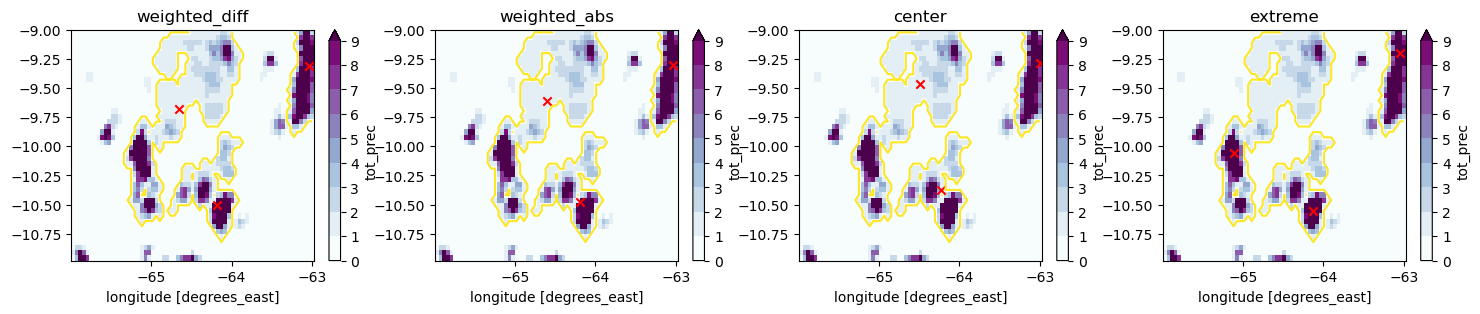

In [33]:
fig_map,ax=plt.subplots(1,4,figsize=(18,3)); xi = -66; xf = -63; yi = -11; yf = -9; tt = '2017-4-3T20:00';
labels=['weighted_diff', 'weighted_abs', 'center' , 'extreme' ]
for i in np.arange(4):
    xr.DataArray.from_iris(test2).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot(ax=ax[i],**paraplot)
    
ax[0].scatter(x=FeatP2diff[pd.to_datetime(FeatP2diff.timestr)==tt]['longitude'].values, 
            y=FeatP2diff[pd.to_datetime(FeatP2diff.timestr)==tt]['latitude'].values, color='r',marker='x', label="Detected Features"); 
xr.DataArray.from_iris(Mask2diff).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot.contour(ax=ax[0],levels=[1],color='orange'); 
ax[1].scatter(x=FeatP2abs[pd.to_datetime(FeatP2abs.timestr)==tt]['longitude'].values, 
            y=FeatP2abs[pd.to_datetime(FeatP2abs.timestr)==tt]['latitude'].values, color='r',marker='x', label="Detected Features"); 
xr.DataArray.from_iris(Mask2abs).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot.contour(ax=ax[1],levels=[1],color='orange'); 
ax[2].scatter(x=FeatP2center[pd.to_datetime(FeatP2center.timestr)==tt]['longitude'].values, 
            y=FeatP2center[pd.to_datetime(FeatP2center.timestr)==tt]['latitude'].values, color='r',marker='x', label="Detected Features"); 
xr.DataArray.from_iris(Mask2center).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot.contour(ax=ax[2],levels=[1],color='orange'); 
ax[3].scatter(x=FeatP2extreme[pd.to_datetime(FeatP2extreme.timestr)==tt]['longitude'].values, 
            y=FeatP2extreme[pd.to_datetime(FeatP2extreme.timestr)==tt]['latitude'].values, color='r',marker='x', label="Detected Features"); 
xr.DataArray.from_iris(Mask2extreme).sel(lat=slice(yi,yf),lon=slice(xi,xf)).sel(time=tt).plot.contour(ax=ax[3],levels=[1],color='orange'); 

for i in np.arange(4):
    ax[i].set_ylabel('');ax[i].set_title(labels[i]);